In [1]:
import ast

import pandas as pd
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
import bokeh.plotting as bpl
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.models import BoxZoomTool, PanTool, WheelZoomTool, HoverTool, Label, ColorBar, BasicTicker, LinearColorMapper
from bokeh.palettes import d3, brewer
from bokeh.io import output_file, reset_output, save, export_png
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.colors import RGB

bpl.output_notebook()

Loading BokehJS ...

In [3]:
cd ..

/Users/gallaghe/Code/nutrition-labels


## Load cluster data

In [4]:
datestamp = '210429'
cluster_grant_data = pd.read_csv(f'data/processed/clustering/cluster_grant_data_{datestamp}.csv')

In [5]:
grant_data = pd.read_csv("data/raw/wellcome-grants-awarded-2005-2019.csv")
cluster_grant_data = pd.merge(
    cluster_grant_data,
    grant_data[['Internal ID', 'Description', 'Title', 'Grant Programme:Title']].drop_duplicates(subset=['Internal ID']),
    how='left', on='Internal ID')

In [6]:
cluster_grant_data.head(2)

,Unnamed: 0,Internal ID,Tech grant?,Cluster number,Tech cluster number,Cluster reduction x,Cluster reduction y,Tech cluster reduction x,Tech cluster reduction y,Description,Title,Grant Programme:Title
0,3864,200176/Z/15/Z,True,0,0.0,3.107835,5.378426,10.558545,8.238167,<p>The objective of this proposal is to discov...,What causes major depression?,Collaborative Award in Science
1,6648,102087/Z/13/Z,True,-1,1.0,7.029790,7.241990,6.959012,9.608910,A Mars exploration game. The challenge is to e...,The Martian Question: A Mars and Biomechanics ...,"Development Fund: Broadcast, Games & Film"


In [7]:
with open(f'data/processed/clustering/cluster_info_{datestamp}.txt', 'r') as file:
    lines = file.readlines()
    cluster_kws = ast.literal_eval(lines[0])
    cluster_centroids = ast.literal_eval(lines[1])
    cluster_numbers = ast.literal_eval(lines[2])

In [8]:
with open(f'data/processed/clustering/tech_cluster_info_{datestamp}.txt', 'r') as file:
    lines = file.readlines()
    tech_cluster_kws = ast.literal_eval(lines[0])
    tech_cluster_centroids = ast.literal_eval(lines[1])
    tech_cluster_numbers = ast.literal_eval(lines[2])

In [9]:
prop_clust_tech = {}
for clust_num, clust_group in cluster_grant_data.groupby('Cluster number'):
    if clust_num == -1:
        prop_clust_tech[clust_num] = 0
    else:
        prop_clust_tech[clust_num] = sum(clust_group['Tech grant?'])/len(clust_group)

In [10]:
cluster_grant_data['Proportion tech in cluster'] = cluster_grant_data['Cluster number'].apply(lambda x: prop_clust_tech[x])

In [12]:
cluster_kws_5 = {k:', '.join(v.split(',')[0:5]) for k,v in cluster_kws.items()}
tech_cluster_kws_5 = {k:', '.join(v.split(',')[0:5]) for k,v in tech_cluster_kws.items()}

### General cluster information

In [13]:
len(cluster_kws_5)

173

In [14]:
len(tech_cluster_kws_5)

30

In [15]:
proportions = list(prop_clust_tech.values())
proportions.sort()

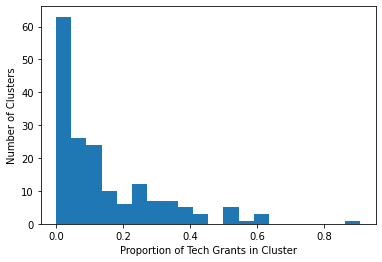

In [16]:
plt.hist(prop_clust_tech.values(), bins=20);
plt.xlabel('Proportion of Tech Grants in Cluster');
plt.ylabel('Number of Clusters');

In [43]:
grant_cluster_info = []
for cluster_num in prop_clust_tech.keys():
    grant_cluster_info.append({
        'Cluster number': cluster_num,
        'Proportion of Tech Grants': prop_clust_tech[cluster_num],
        'Number of Grants': cluster_numbers[cluster_num],
        'Keywords': cluster_kws[cluster_num] 
    })
    
grant_cluster_info = pd.DataFrame(grant_cluster_info)
grant_cluster_info.sort_values('Proportion of Tech Grants', inplace=True)

In [18]:
pd.set_option('display.max_colwidth', None)

In [44]:
# Top 10 tech clusters
grant_cluster_info.tail(10)

,Cluster number,Proportion of Tech Grants,Number of Grants,Keywords
8,7,0.500000,10,"language,stroke,recovery,aphasia,patient,task,aphasic,neuronal,damage,speech"
149,148,0.500000,8,"stroke,hai,patient,treatment,dar,ssa,dysphagia,case,wgas,salaam"
59,58,0.500000,12,"asd,autism,disorder,spectrum,child,young,social,model,developmental,mouse"
31,30,0.500000,16,"cvd,risk,cardiovascular,country,factor,disease,pune,healthcare,lac,adult"
85,84,0.500000,20,"flow,cell,cytometry,sorter,cytometer,research,biology,facility,parameter,chromosome"
40,39,0.564103,39,"cryo,em,electron,resolution,macromolecular,structure,facility,microscopy,structural,microscope"
7,6,0.597087,206,"genetic,variant,genome,sequence,datum,locus,association,disease,genotype,study"
6,5,0.625000,24,"game,player,world,virtual,3d,immerse,vr,star,pet,story"
167,166,0.625000,8,"zikv,zika,congenital,microcephaly,infection,chikv,vietnam,brazil,syndrome,campina"
35,34,0.909091,110,"datum,resource,database,twin,access,analysis,open,cohort,software,research"


In [45]:
# Least 10 tech clusters, but since many are proportion =0 with a
# small number in the cluster, only include those with >x number grants
threshold_n = 30
print(len(grant_cluster_info[grant_cluster_info['Number of Grants']<threshold_n]))
grant_cluster_info[grant_cluster_info['Number of Grants']>=threshold_n].head(11).round(3)

108


,Cluster number,Proportion of Tech Grants,Number of Grants,Keywords
0,-1,0.000,1500,"research,disease,cell,health,study,project,patient,model,datum,drug"
130,129,0.000,32,"trypanosome,vsg,tsetse,brucei,stumpy,fly,expression,gene,parasite,cell"
122,121,0.000,38,"hif,hypoxia,oxygen,hypoxic,vhl,response,hydroxylase,cell,pathway,inducible"
114,113,0.000,45,"pain,dorsal,chronic,spinal,horn,neuropathic,peripheral,neuron,nociceptive,sensory"
110,109,0.000,31,"replication,dna,origin,fork,replisome,helicase,cell,genome,duplication,eukaryotic"
46,45,0.012,81,"dna,repair,damage,protein,ddr,repeat,cell,break,dsb,hr"
22,21,0.017,757,"medical,medicine,history,conference,research,health,practice,modern,century,work"
105,104,0.019,54,"nk,cell,hcmv,hla,kir,htlv,infection,hcv,latency,trophoblast"
94,93,0.020,49,"war,forensic,military,medical,british,veteran,world,medicine,project,history"
128,127,0.021,48,"secretion,effector,host,salmonella,cell,bacterial,protein,pathogen,t3ss,virulence"


### Biggest tech clusters

In [48]:
tech_grant_cluster_info = []
for cluster_num in tech_cluster_numbers.keys():
    tech_grant_cluster_info.append({
        'Cluster number': cluster_num,
        'Number of Grants': tech_cluster_numbers[cluster_num],
        'Keywords': tech_cluster_kws[cluster_num] 
    })
    
tech_grant_cluster_info = pd.DataFrame(tech_grant_cluster_info)
tech_grant_cluster_info.sort_values('Number of Grants', inplace=True, ascending=False)

In [49]:
tech_grant_cluster_info.head(11)

,Cluster number,Number of Grants,Keywords
5,5,294,"brain,model,neural,neuron,visual,network,process,task,learn,decision"
0,0,230,"gene,genome,sequence,variant,datum,analysis,disease,study,phenotype,method"
2,2,193,"health,research,datum,policy,intervention,care,population,change,public,mortality"
8,8,164,"virus,transmission,malaria,infection,host,datum,disease,influenza,model,pathogen"
29,-1,132,"image,model,disease,patient,research,cell,datum,use,muscle,study"
4,4,132,"protein,structural,structure,ms,mass,cryo,membrane,complex,proteomics,high"
12,12,117,"datum,patient,hospital,risk,health,disease,study,cohort,cvd,care"
7,7,60,"cell,image,tissue,stem,fate,flow,progenitor,model,single,high"
13,13,41,"coronary,cardiac,heart,patient,pressure,flow,artery,myocardial,drug,blood"
9,9,39,"datum,database,resource,community,open,research,platform,access,tool,intermine"


## Plot functions

In [23]:
# convert colours to hex to fit to bokeh
def convert_hex(rgb_colour_list):
    return ["#%02x%02x%02x" % (int(r*255), int(g*255), int(b*255)) for r, g, b in rgb_colour_list]

In [75]:
def plot_clusters(
        data, cluster_num_col, x_red_col, y_red_col,
        colour_by, cluster_kw_label_dict, alpha=0.5,size=5,plot_width=800, plot_height=800,
        cluster_kws=None, cluster_centroids=None,label_font_size=2,
        save_html_file=None, save_png_file=None,title='Grants'):
    titles = data['Title'].tolist()
    texts = [g[0:300] for g in data['Description'].tolist()]
    grant_ids = data['Internal ID'].tolist()

    x = data[x_red_col]
    y = data[y_red_col]
    kws = [cluster_kw_label_dict[c] for c in data[cluster_num_col]]

    if colour_by=='cluster':
        clust_num = data[cluster_num_col].astype(int)
        colour_by_name = "Cluster number"
        colors = [(0.8,0.8,0.8)] + [(r,g,b) for r,g,b,a in cm.gist_ncar(np.linspace(0, 1, np.max(clust_num)+2))]
        color_clust = [(colors[c+1]) for c in clust_num]
    if colour_by=='tech_or_not':
        clust_num = data['Tech grant?'].tolist()
        colour_by_name = "Tech grant?"
        colors = [(0.8,0.8,0.8), (0,0,1)]
        color_clust = [(colors[c]) for c in clust_num]
    if colour_by=='prop_tech':
        clust_num = data['Proportion tech in cluster']
        colour_by_name = "Proportion of tech in this cluster"
#         color_clust = [(max(0,0.7-c),0,c) for c in clust_num]
        colors = [(r,g,b) for r,g,b,a in cm.plasma(np.linspace(0, 1, 100))]
        color_clust = [(colors[round(c*100)]) for c in clust_num]

    source = ColumnDataSource(data=dict(
            x=x, y=y, title=titles,
            texts=texts, cluster_col=convert_hex(color_clust),
            cluster=clust_num, grant_id = grant_ids, kws=kws
    ))
    hover = HoverTool(tooltips=[
        ("Grant ID", "@grant_id"),
        ("Text", "@texts"),
        (colour_by_name, "@cluster"),
        ("Cluster keywords", '@kws')
    ])

    p = figure(plot_width=plot_width, plot_height=plot_height,
               tools=[hover, WheelZoomTool(), BoxZoomTool(), PanTool()],
               title=title, toolbar_location="below")
    p.axis.visible = False

    p.circle('x', 'y', color='cluster_col', alpha=alpha, size=size, source=source)

    if colour_by=='prop_tech':
        m_coolwarm_rgb = (255 * cm.plasma(range(256))).astype('int')
        coolwarm_palette = [RGB(*tuple(rgb)).to_hex() for rgb in m_coolwarm_rgb]
        color_mapper = LinearColorMapper(palette=coolwarm_palette, low=0, high=1)
        color_bar = ColorBar(color_mapper=color_mapper, ticker= BasicTicker(),
                         location=(0,0))
        p.add_layout(color_bar, 'right')

    if colour_by=='tech_or_not':
        # Find one tech and one not tech index, and plot these again but
        # with legends
        index_one_tech = cluster_grant_data.index[cluster_grant_data['Tech grant?']==True].tolist()[0]
        index_one_nottech = cluster_grant_data.index[cluster_grant_data['Tech grant?']==False].tolist()[0]
        p.circle(x.tolist()[index_one_tech], y.tolist()[index_one_tech],
                 legend_label="Tech Grant",
                 color = convert_hex([(0,0,1)]), alpha=1, size=size)
        p.circle(x.tolist()[index_one_nottech], y.tolist()[index_one_nottech],
                 legend_label="Not Tech Grant",
                 color = convert_hex([(0.8,0.8,0.8)]), alpha=1, size=size)
        
    if cluster_kws:
        for cluster_num, cluster_kw in cluster_kws.items():
            citation = Label(
                x=cluster_centroids[cluster_num][0],
                y=cluster_centroids[cluster_num][1],
                text=cluster_kw, render_mode='css',
                background_fill_color='white', background_fill_alpha=0.6, text_font_size=f'{label_font_size}px'
            )
            p.add_layout(citation)
    p.xgrid.visible = False
    p.ygrid.visible = False

    if save_html_file:
        output_file(f'{save_html_file}.html')
        save(p)
    else:
        show(p)

### Plot all grant clusters

In [88]:
label_len_thresh = 80
cluster_kws_2 = {k:','.join(v.split(',')[0:2]) if cluster_numbers[k]>label_len_thresh else '' for k,v in cluster_kws.items()}

In [89]:
plot_clusters(
    data=cluster_grant_data[pd.notnull(cluster_grant_data['Cluster number'])],
    cluster_num_col='Cluster number',
    x_red_col='Cluster reduction x',
    y_red_col='Cluster reduction y',
    colour_by='cluster',
    cluster_kw_label_dict=cluster_kws_5,
    alpha=0.3,
    size=4,
    plot_width=700,
    plot_height=700,
    cluster_kws=cluster_kws_2, cluster_centroids=cluster_centroids,label_font_size=15,
    title='All Grants',
    save_html_file=f'models/clustering/{datestamp}/all_clusters_gt_{label_len_thresh}'
#     save_html_file=f'models/clustering/{datestamp}/all_clusters_no_label'
)

### Plot all grant clusters coloured by tech or not

In [80]:
plot_clusters(
    data=cluster_grant_data[pd.notnull(cluster_grant_data['Cluster number'])],
    cluster_num_col='Cluster number',
    x_red_col='Cluster reduction x',
    y_red_col='Cluster reduction y',
    colour_by='tech_or_not',
    cluster_kw_label_dict=cluster_kws_5,
    alpha=0.5,
    size=4,
    plot_width=700,
    plot_height=700,
    title='All Grants - Tech or not',
    save_html_file=f'models/clustering/{datestamp}/tech_grants')

###  Proportion of tech grants in cluster

In [50]:
# Plot labels of top proportions and lowest proportions, only if
# number in cluster is >20 though (otherwise crowded)
proportions = list(prop_clust_tech.values())
proportions.sort()
top_thresh = proportions[-6]
low_thresh = proportions[6]

In [77]:
label_len_thresh = 0
cluster_top_low_kws_2 = {k:','.join(v.split(',')[0:2]) if cluster_numbers[k]>label_len_thresh and (prop_clust_tech[k]>=top_thresh or prop_clust_tech[k]<=low_thresh) else '' for k,v in cluster_kws.items()}

In [79]:
plot_clusters(
    data=cluster_grant_data[pd.notnull(cluster_grant_data['Cluster number'])],
    cluster_num_col='Cluster number',
    x_red_col='Cluster reduction x',
    y_red_col='Cluster reduction y',
    colour_by='prop_tech',
    cluster_kw_label_dict=cluster_kws_5,
    alpha=0.7,
    size=4,
    plot_width=760,
    plot_height=700,
#     cluster_kws=cluster_top_low_kws_2, cluster_centroids=cluster_centroids,label_font_size=15,
    title ='All Grants - coloured by proportion of tech grants in cluster',
#     save_html_file=f'models/clustering/{datestamp}/tech_prop_clusters_gt_{label_len_thresh}'
    save_html_file=f'models/clustering/{datestamp}/tech_prop_clusters_no_labels'
)

### Tech clusters

In [90]:
tech_cluster_kws_2 = {k:','.join(v.split(',')[0:2]) if tech_cluster_numbers[k]>0 else '' for k,v in tech_cluster_kws.items()}

In [91]:
plot_clusters(
    data=cluster_grant_data[pd.notnull(cluster_grant_data['Tech cluster number'])],
    cluster_num_col='Tech cluster number',
    x_red_col='Tech cluster reduction x',
    y_red_col='Tech cluster reduction y',
    colour_by='cluster',
    cluster_kw_label_dict=tech_cluster_kws_5,
    alpha=0.7,
    size=6,
    plot_width=700,
    plot_height=700,
    title='Tech Grants',
    cluster_kws=tech_cluster_kws_2, cluster_centroids=tech_cluster_centroids,label_font_size=15,
    save_html_file=f'models/clustering/{datestamp}/tech_clusters')

### Where do Biomedical Resources Grant and Technology Development Grant sit?

In [92]:
cluster_grant_data['Biomedical RG'] = (cluster_grant_data['Grant Programme:Title']=='Biomedical Resources Grant').apply(lambda x: int(x)-1)
plot_clusters(
    data=cluster_grant_data[pd.notnull(cluster_grant_data['Tech cluster number'])],
    cluster_num_col='Biomedical RG',
    x_red_col='Tech cluster reduction x',
    y_red_col='Tech cluster reduction y',
    colour_by='cluster',
    cluster_kw_label_dict=cluster_kws_5,
    alpha=0.6,
    size=7,
    plot_width=700,
    plot_height=700,
    title = 'Biomedical Resources Grants',
    save_html_file=f'models/clustering/{datestamp}/BiomedicalRG')

In [93]:
cluster_grant_data['Technology Development Grant'] = (cluster_grant_data['Grant Programme:Title']=='Technology Development Grant').apply(lambda x: int(x)-1)
plot_clusters(
    data=cluster_grant_data[pd.notnull(cluster_grant_data['Tech cluster number'])],
    cluster_num_col='Technology Development Grant',
    x_red_col='Tech cluster reduction x',
    y_red_col='Tech cluster reduction y',
    colour_by='cluster',
    cluster_kw_label_dict=cluster_kws_5,
    alpha=0.6,
    size=7,
    plot_width=700,
    plot_height=700,
    title='Technology Development Grant',
    save_html_file=f'models/clustering/{datestamp}/TechDevGrant')